In [1]:
# install gym and keras-rl, pygame before you run the folowing codes
# install stable_baselines3
import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
# import keras 
# import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 
from time import sleep

# from rl.agents.dqn import DQNAgent
# from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
# from rl.memory import SequentialMemory
# from rl.core import Processor
# from rl.callbacks import FileLogger, ModelIntervalCheckpoint
print("OK")

OK


Let's design a simulation of a self-driving cab. The major goal is to demonstrate, in a simplified environment, how you can use RL techniques to develop an efficient and safe approach for tackling this problem.

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

- Drop off the passenger to the right location.
- Save passenger's time by taking minimum time possible to drop off
- Take care of passenger's safety and traffic rules

There are different aspects that need to be considered here while modeling an RL solution to this problem: rewards, states, and actions.

# 1. Reward

Since the agent (the imaginary driver) is reward-motivated and is going to learn how to control the cab by trial experiences in the environment, we need to decide the rewards and/or penalties and their magnitude accordingly. Here a few points to consider:

- The agent should receive a high positive reward for a successful dropoff because this behavior is highly desired
- The agent should be penalized if it tries to drop off a passenger in wrong locations
- The agent should get a slight negative reward for not making it to the destination after every time-step. "Slight" negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible


# 2. State Space

In Reinforcement Learning, the agent encounters a state, and then takes action according to the state it's in.

The State Space is the set of all possible situations our taxi could inhabit. The state should contain useful information the agent needs to make the right action.

Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):


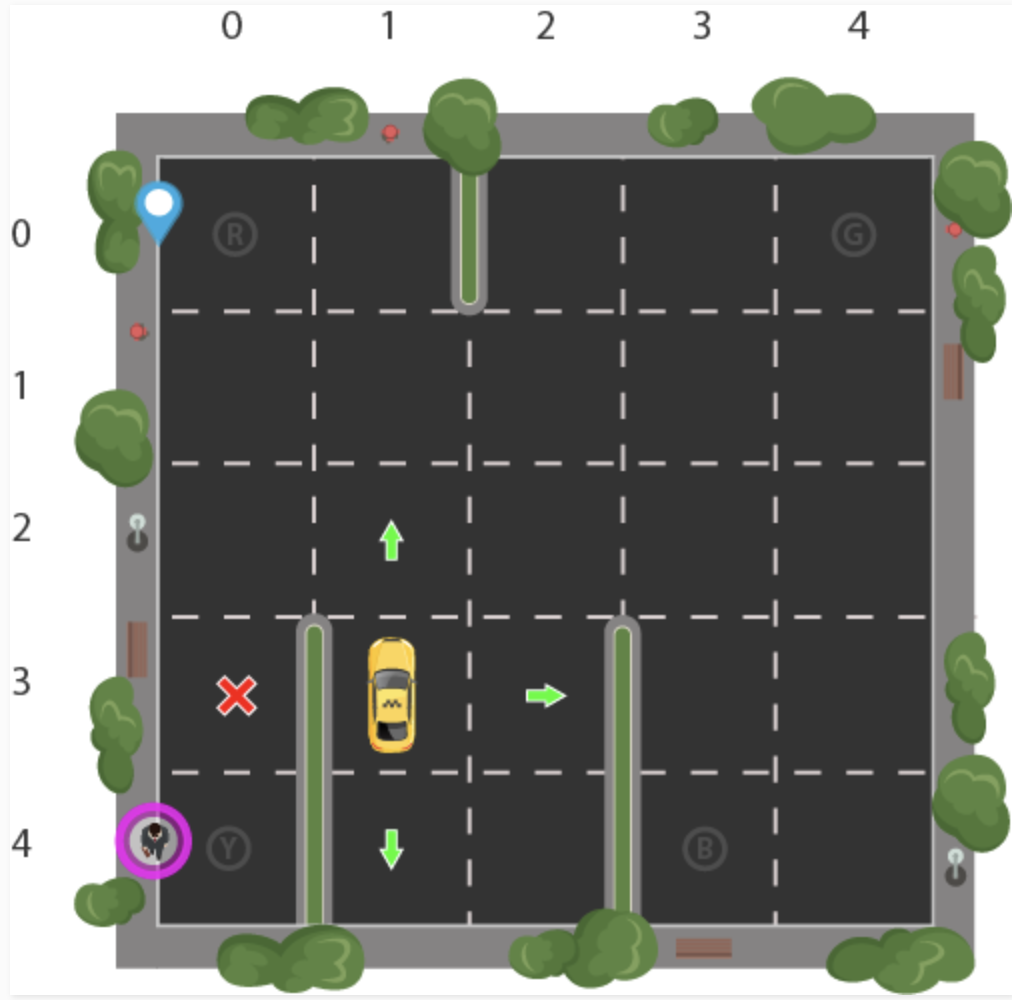

In [13]:
# do not compile this cell
from IPython.display import Image 
Image("cab.png", width=500, height=500)

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or [(0,0), (0,4), (4,0), (4,3)] in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

When we also account for one (1) additional passenger state of being inside the taxi, we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there's four (4) destinations and five (4 + 1) passenger locations.

So, our taxi environment has  total 25x5x4 = 500 possible states.

# 3. Action Space
The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger.

In other words, we have six possible actions:
- south
- north
- east
- west
- pickup
- dropoff

This is the **action space**: the set of all the actions that our agent can take in a given state.

You'll notice in the illustration above, that the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a **penalty with value -1** for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

# Install the Environmet

Fortunately, OpenAI Gym has this exact environment already built for us.

Gym provides different game environments which we can plug into our code and test an agent. The library takes care of API for providing all the information that our agent would require, like possible actions, score, and current state. We just need to focus just on the algorithm part for our agent.

We'll be using the Gym environment called Taxi-v3, which all of the details explained above were pulled from. The objectives, rewards, and actions are all the same.

In [2]:
!pip install cmake 'gym[atari]' scipy
print("OK")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 30.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 38.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.4 which is incompatible.
OK


In [5]:
# Gym's interface
# We need to install gym first. Executing the following in a Jupyter notebook should work:

import gym

# env = gym.make("Taxi-v3").env
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()


(353, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

In [6]:
# Once installed, we can load the game environment and render what it looks like:

env.reset() # reset environment to a new, random state
env.render() # install stable_baselines3 if you have problem with env.render()
 
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


The core gym interface is env, which is the unified environment interface. The following are the env methods that would be quite helpful to us:

- env.reset: Resets the environment and returns a random initial state.
- env.step(action): Step the environment by one timestep. Returns
-- observation: Observations of the environment
-- reward: If your action was beneficial or not
-- done: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
-- info: Additional info such as performance and latency for debugging purposes
- env.render: Renders one frame of the environment (helpful in visualizing the environment)

Note: We are using the .env on the end of make to avoid training stopping at 200 iterations, which is the default for the new version of Gym.



# Description of the Problem with the Environment
Here's our restructured problem statement (from Gym docs):

"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

Let's dive more into the environment.

In [ ]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

- The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
- The pipe ("|") represents a wall which the taxi cannot cross.
- R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

As verified by the prints, we have an Action Space of size 6 and a State Space of size 500. As you'll see, our RL algorithm won't need any more information than these two things. All we need is a way to identify a state uniquely by assigning a unique number to every possible state, and RL learns to choose an action number from 0-5 where:

- 0 = south
- 1 = north
- 2 = east
- 3 = west
- 4 = pickup
- 5 = dropoff

Recall that the 500 states correspond to a encoding of the taxi's location, the passenger's location, and the destination location.

Reinforcement Learning will learn a mapping of states to the optimal action to perform in that state by exploration, i.e. the agent explores the environment and takes actions based off rewards defined in the environment.

The optimal action for each state is the action that has the highest cumulative long-term reward.

We can actually take our illustration above, encode its state, and give it to the environment to render in Gym. Recall that we have the taxi at row 3, column 1, our passenger is at location 2, and our destination is location 0. Using the Taxi-v2 state encoding method, we can do the following:

In [7]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328


array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]

We are using our illustration's coordinates to generate a number corresponding to a state between 0 and 499, which turns out to be 328 for our illustration's state.

Then we can set the environment's state manually with env.env.s using that encoded number. You can play around with the numbers and you'll see the taxi, passenger, and destination move around.

### The Reward Table

When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a  matrix.

Since every state is in this matrix, we can see the default reward values assigned to our illustration's state:



In [8]:
env.P[328] # This dictionary has the structure {action: [(probability, nextstate, reward, done)]}.


{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

A few things to note:

- The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
- In this env, probability is always 1.0.
- The nextstate is the state we would be in if we take the action at this index of the dict
- All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5) 
- done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode


Note that if our agent chose to explore action two (2) in this state it would be going East into a wall. The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accruing -1 penalties, which affects the long-term reward.

# Q-learning Implementation (Homework Question Starts Here!)

**Question 1**: Implement the Q-learning update at the indicated place. You should follow the following equation:
$$Q_{new}(s,a) = (1-\alpha)Q_{old}(s,a) + \alpha  * (r + \gamma * max_{a'} Q_{old}(s',a'))$$
- What are the values of q_table[1,1] and q_table[51,3]?
- Visualize the array sum_q_arr and explain if the algorithm has converged or not.



**Question 2**: What are the average penalties reported under the evaluation module? Explain the idea of the desgin.

In [9]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [10]:
sum_q_arr = np.zeros(100001)

In [12]:
%%time
"""Question 1: Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1 # learning rate
gamma = 0.6 # discount factor
epsilon = 0.1 # probability to randomly explore an action

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()
    state = state if (type(state)==int) else state[0]
    
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info, _ = env.step(action) 
        next_state = next_state if type(next_state)==int else next_state[0]
        
        ### Implement here! ####
        #Update q_table using new data (state, action, next_state, reward)
        

        
        ########################

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    sum_q_arr[i] = np.sum(q_table)    
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: user 33.5 s, sys: 2.64 s, total: 36.1 s
Wall time: 33.7 s


In [15]:
"""Question 2: Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    state = state if (type(state)==int) else state[0]
    
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info, _ = env.step(action)
        state = state if (type(state)==int) else state[0]

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.6
Average penalties per episode: 0.0
